[View in Colaboratory](https://colab.research.google.com/github/zeeshanhaider1007/MatchNet-with-Triplet-Loss/blob/master/triplet_loss_keras_no_distance_layer_64_64_1.ipynb)

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18396 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8.1) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .

Setting up libkmod2:amd64 (24-1ubuntu2) ...
Setting up gir1.2-glib-2.0:amd64 (1.54.1-1) ...
Processing triggers for libc-bin (2.26-0ubuntu2.1) ...
Setting up libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Setting up unattended-upgrades (0.98ubuntu1.1) ...

Creating config file /etc/apt/apt.conf.d/20auto-upgrades with new version

Creating config file /etc/apt/apt.conf.d/50unattended-upgrades with new version
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up dirmngr (2.1.15-1ubuntu8.1) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arguments (1) do not match cron Default-Stop values (none)
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up kmod (24

In [0]:
from google.colab import auth
auth.authenticate_user()

In [3]:
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p my_drive
!google-drive-ocamlfuse my_drive

In [5]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
import sys
import random
import h5py
from PIL import Image
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import *
from keras.layers import Input, Flatten, Dense, Dropout, Lambda,Conv2D, MaxPooling2D,concatenate,Concatenate,BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import RMSprop,Adam
from keras import backend as K
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [6]:
epoch = 80
Batch_Size=64
learning_rate=1e-3
name="triplet_dataset123"
path= './my_drive/app/'
data_path = path+name

print(data_path)
activ="LeakyReLU"
##name of storing models
#dataset_activation_epochs
FC_model=path+"_"+name+"_"+activ+"LeakyReLU_bachnormalization"+"_80_FC_modified_triplet_weights.h5"
feature_model=path+"_"+name+"_"+activ+"LeakyReLU_batchnormalization"+"_80_feature_model_.h5"


./my_drive/app/triplet_dataset123


In [0]:
def load_data(data_path):
    with h5py.File(data_path+".h5",'r') as hdf: 
#    hdf.create_dataset(name="anchor_pairs",data=x_train))
        x=np.array(hdf.get("anchor_pairs"))
    return x


In [0]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

In [0]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    print ("euclidean shape",(shape1[0], 1))
    return (shape1[0], 1)

In [0]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) +
                  (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [0]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """
    print ("predicted tensor")
    print (y_pred.shape)
    anchor=y_pred[:,0:4096]
    positive = y_pred[:,4096:8192]
    print ("positive loss",positive.shape)
    negative = y_pred[:,8192:12288]
    print ("negative loss",negative.shape)

    # distance between 

    # compute loss
    pos_dist = K.sum(K.square(anchor-positive),axis=1)
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
    print ("loss",loss)
    return loss


In [0]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    print ("entering network")
    input = Input(shape=input_shape)
    print (input.shape)
    x=Conv2D(24, (7, 7),strides=1,kernel_initializer="glorot_normal", padding='same')(input)
    x=BatchNormalization(momentum=0.99, epsilon=0.001, beta_initializer='zeros', gamma_initializer='ones')(x)
    x=LeakyReLU(alpha=.001)(x)
    print (x.shape)
    x=MaxPooling2D((2, 2),strides=2)(x)
    print (x.shape)
    x=Conv2D(64, (5, 5),strides=1, kernel_initializer="glorot_normal", padding='same')(x)
    x=BatchNormalization(momentum=0.99, epsilon=0.001, beta_initializer='zeros', gamma_initializer='ones')(x)
    x=LeakyReLU(alpha=.001)(x)
    print (x.shape)
    x=MaxPooling2D((2, 2),strides=2)(x)
    print (x.shape)
    x=Conv2D(96, (3, 3),strides=1 ,kernel_initializer="glorot_normal", padding='same')(x)
    x=BatchNormalization(momentum=0.99, epsilon=0.001, beta_initializer='zeros', gamma_initializer='ones')(x)
    x=LeakyReLU(alpha=.001)(x)
    print (x.shape)
    x=Conv2D(96, (2, 2),strides=1,kernel_initializer="glorot_normal", padding='same')(x)
    x=BatchNormalization(momentum=0.99, epsilon=0.001, beta_initializer='zeros', gamma_initializer='ones')(x)
    x=LeakyReLU(alpha=.001)(x)
    print (x.shape)
    x=Conv2D(64, (3, 3),strides=1,kernel_initializer="glorot_normal", padding='same')(x)
    x=BatchNormalization(momentum=0.99, epsilon=0.001, beta_initializer='zeros', gamma_initializer='ones')(x)
    x=LeakyReLU(alpha=.001)(x)
    print (x.shape)
    x=MaxPooling2D((2, 2),strides=2)(x)
    print (x.shape)
    x=Flatten()(x)
    print (x.shape)
    print ("exiting network")
    return Model(input, x)

In [0]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [0]:
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


In [85]:
##comparison  anchor
print(data_path)
x=load_data(data_path)
x=np.array((x),dtype=np.uint8)
data_instances=x.shape[0]
print (x.shape)

#Image.fromarray(x[10,0,:,:,:],'RGB').show()
#Image.fromarray(x[10,1,:,:,:],'RGB').show()
#Image.fromarray(x[10,2,:,:,:],'RGB').show()



./my_drive/app/triplet_dataset123
(10000, 3, 64, 64)


(10000, 3, 64, 64)


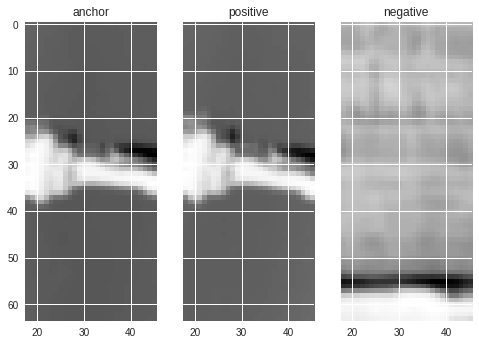

In [86]:

f, (ax1, ax2,ax3) = plt.subplots(1, 3, sharey=True)
num=int(random.randint(1,data_instances)%data_instances)
#anchor_im=[255*(x[d,0,:,:]/x[d,0,:,:].max())for d in range(data_instances)]
#pos_im=[255*x[d,0,:,:]/x[d,0,:,:].max() for d in range(data_instances)]
#neg_im=[255*x[d,0,:,:]/x[d,0,:,:].max() for d in range(data_instances)]
#anchor_im=np.array((anchor_im), dtype =np.uint8)
#img = anchor_im.astype(np.uint8)
#ax1.imshow(img[0,:,:])
ax1.imshow(x[num,0,:,:])
ax1.set_title('anchor')
ax2.imshow(x[num,1,:,:])
ax2.set_title('positive')
ax3.imshow(x[num,2,:,:])
ax3.set_title('negative')
print (x.shape)

In [87]:
print (num)

2465


In [88]:
in_dims = (64,64,1)
out_dims = (8,8,64)

# Network definition
#with tf.device(tf_device):

# Create the 3 inputs
anchor_in = Input(shape=in_dims,name="anchor")
pos_in = Input(shape=in_dims,name="positive")
neg_in = Input(shape=in_dims,name="negative")

# Share base network with the 3 inputs
base_network = create_base_network(in_dims)
anchor_out = base_network(anchor_in)
pos_out = base_network(pos_in)
neg_out = base_network(neg_in)

#lamda layer
#pos_distance = Lambda(euclidean_distance,output_shape=eucl_dist_output_shape)([anchor_out,pos_out])
#print ("positive dist",pos_distance.shape)
#neg_distance = Lambda(euclidean_distance,output_shape=eucl_dist_output_shape)([anchor_out,neg_out])
#print ("negative dist",neg_distance.shape)

#
#print ("concatenated",merged_vector.shape)
#model = Model(inputs=[anchor_in, pos_in, neg_in], outputs=merged_vector)

merged_vector = concatenate([anchor_out, pos_out, neg_out],axis=-1)

# Define the trainable model
model = Model(inputs=[anchor_in, pos_in, neg_in], outputs=merged_vector)


entering network
(?, 64, 64, 1)
(?, 64, 64, 24)
(?, 32, 32, 24)
(?, 32, 32, 64)
(?, 16, 16, 64)
(?, 16, 16, 96)
(?, 16, 16, 96)
(?, 16, 16, 64)
(?, 8, 8, 64)
(?, ?)
exiting network


In [89]:
model.compile(optimizer=Adam(lr=learning_rate),
              loss=triplet_loss)
#sys.exit(0)
y_dummie=np.zeros((len(x)))
# Training the model
x=np.reshape((x),(10000,3,64,64,1))
model.fit([x[:,0,:,:],x[:,1,:,:],x[:,2,:,:]], y_dummie,validation_split=0.2,batch_size=64, epochs=epoch)

predicted tensor
(?, ?)
positive loss (?, ?)
negative loss (?, ?)
loss Tensor("loss_9/concatenate_7_loss/Maximum:0", shape=(?,), dtype=float32)
Train on 8000 samples, validate on 2000 samples
Epoch 1/80
8000/8000 [==============================] - 25s 3ms/step - loss: 7.5858 - val_loss: 0.6886
Epoch 2/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.2848 - val_loss: 0.3046
Epoch 3/80
2496/8000 [========>.....................] - ETA: 13s - loss: 0.1300

8000/8000 [==============================] - 22s 3ms/step - loss: 0.1340 - val_loss: 0.1891
Epoch 4/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0840 - val_loss: 0.1088
Epoch 5/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0606 - val_loss: 0.0791
Epoch 6/80
6528/8000 [=======================>......] - ETA: 3s - loss: 0.0487

8000/8000 [==============================] - 22s 3ms/step - loss: 0.0462 - val_loss: 0.0690
Epoch 7/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0357 - val_loss: 0.0573
Epoch 8/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0296 - val_loss: 0.0488
Epoch 9/80
7232/8000 [==========================>...] - ETA: 1s - loss: 0.0261

8000/8000 [==============================] - 22s 3ms/step - loss: 0.0251 - val_loss: 0.0488
Epoch 10/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0233 - val_loss: 1.2207
Epoch 11/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0197 - val_loss: 0.0383
Epoch 12/80
7232/8000 [==========================>...] - ETA: 1s - loss: 0.0184

8000/8000 [==============================] - 22s 3ms/step - loss: 0.0181 - val_loss: 0.0340
Epoch 13/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0165 - val_loss: 0.0324
Epoch 14/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0148 - val_loss: 0.0309
Epoch 15/80
7232/8000 [==========================>...] - ETA: 1s - loss: 0.0143

8000/8000 [==============================] - 22s 3ms/step - loss: 0.0150 - val_loss: 0.0304
Epoch 16/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0130 - val_loss: 0.0298
Epoch 17/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0117 - val_loss: 0.0322
Epoch 18/80
7232/8000 [==========================>...] - ETA: 1s - loss: 0.0108

8000/8000 [==============================] - 22s 3ms/step - loss: 0.0110 - val_loss: 0.0283
Epoch 19/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0116 - val_loss: 0.0273
Epoch 20/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0108 - val_loss: 0.0292
Epoch 21/80
7232/8000 [==========================>...] - ETA: 1s - loss: 0.0085

8000/8000 [==============================] - 22s 3ms/step - loss: 0.0092 - val_loss: 0.0280
Epoch 22/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0101 - val_loss: 0.0277
Epoch 23/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0089 - val_loss: 0.0256
Epoch 24/80
7232/8000 [==========================>...] - ETA: 1s - loss: 0.0095

8000/8000 [==============================] - 22s 3ms/step - loss: 0.0093 - val_loss: 0.0254
Epoch 25/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0072 - val_loss: 0.0273
Epoch 26/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0086 - val_loss: 0.0259
Epoch 27/80
7232/8000 [==========================>...] - ETA: 1s - loss: 0.0062

8000/8000 [==============================] - 22s 3ms/step - loss: 0.0064 - val_loss: 0.0279
Epoch 28/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0066 - val_loss: 0.0264
Epoch 29/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0106 - val_loss: 0.1056
Epoch 30/80
7232/8000 [==========================>...] - ETA: 1s - loss: 0.0061

8000/8000 [==============================] - 22s 3ms/step - loss: 0.0064 - val_loss: 0.0265
Epoch 31/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0082 - val_loss: 0.0327
Epoch 32/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0084 - val_loss: 0.0367
Epoch 33/80
7232/8000 [==========================>...] - ETA: 1s - loss: 0.0068

8000/8000 [==============================] - 22s 3ms/step - loss: 0.0073 - val_loss: 0.0291
Epoch 34/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0066 - val_loss: 0.2282
Epoch 35/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0076 - val_loss: 0.0311
Epoch 36/80
7232/8000 [==========================>...] - ETA: 1s - loss: 0.0081

8000/8000 [==============================] - 22s 3ms/step - loss: 0.0076 - val_loss: 0.0262
Epoch 37/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0060 - val_loss: 0.0254
Epoch 38/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0081 - val_loss: 0.0296
Epoch 39/80
7232/8000 [==========================>...] - ETA: 1s - loss: 0.0055

8000/8000 [==============================] - 22s 3ms/step - loss: 0.0052 - val_loss: 0.0310
Epoch 40/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0067 - val_loss: 0.0277
Epoch 41/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0057 - val_loss: 0.0237
Epoch 42/80
7232/8000 [==========================>...] - ETA: 1s - loss: 0.0069

8000/8000 [==============================] - 22s 3ms/step - loss: 0.0068 - val_loss: 0.0402
Epoch 43/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0065 - val_loss: 0.2350
Epoch 44/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0061 - val_loss: 0.0321
Epoch 45/80
7232/8000 [==========================>...] - ETA: 1s - loss: 0.0080

8000/8000 [==============================] - 22s 3ms/step - loss: 0.0076 - val_loss: 0.0261
Epoch 46/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0041 - val_loss: 0.0246
Epoch 47/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0055 - val_loss: 0.0285
Epoch 48/80
7232/8000 [==========================>...] - ETA: 1s - loss: 0.0045

8000/8000 [==============================] - 22s 3ms/step - loss: 0.0045 - val_loss: 0.0266
Epoch 49/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0058 - val_loss: 0.0268
Epoch 50/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0061 - val_loss: 0.0294
Epoch 51/80
7232/8000 [==========================>...] - ETA: 1s - loss: 0.0047

8000/8000 [==============================] - 22s 3ms/step - loss: 0.0047 - val_loss: 0.0457
Epoch 52/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0046 - val_loss: 0.0265
Epoch 53/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0050 - val_loss: 0.0379
Epoch 54/80
7232/8000 [==========================>...] - ETA: 1s - loss: 0.0038

8000/8000 [==============================] - 22s 3ms/step - loss: 0.0038 - val_loss: 0.0337
Epoch 55/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0057 - val_loss: 0.0422
Epoch 56/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0056 - val_loss: 0.0237
Epoch 57/80
7232/8000 [==========================>...] - ETA: 1s - loss: 0.0049

8000/8000 [==============================] - 22s 3ms/step - loss: 0.0051 - val_loss: 0.2529
Epoch 58/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0030 - val_loss: 0.0288
Epoch 59/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0035 - val_loss: 0.0323
Epoch 60/80
7232/8000 [==========================>...] - ETA: 1s - loss: 0.0050

8000/8000 [==============================] - 22s 3ms/step - loss: 0.0050 - val_loss: 0.0221
Epoch 61/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0051 - val_loss: 0.1870
Epoch 62/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0036 - val_loss: 0.0243
Epoch 63/80
7232/8000 [==========================>...] - ETA: 1s - loss: 0.0042

8000/8000 [==============================] - 22s 3ms/step - loss: 0.0046 - val_loss: 0.0349
Epoch 64/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0045 - val_loss: 0.0268
Epoch 65/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0050 - val_loss: 0.0224
Epoch 66/80
7232/8000 [==========================>...] - ETA: 1s - loss: 0.0025

8000/8000 [==============================] - 22s 3ms/step - loss: 0.0027 - val_loss: 0.0719
Epoch 67/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0029 - val_loss: 0.0344
Epoch 68/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0041 - val_loss: 0.0287
Epoch 69/80
7232/8000 [==========================>...] - ETA: 1s - loss: 0.0036

8000/8000 [==============================] - 22s 3ms/step - loss: 0.0038 - val_loss: 0.0324
Epoch 70/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0042 - val_loss: 0.0200
Epoch 71/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0041 - val_loss: 0.0257
Epoch 72/80
7232/8000 [==========================>...] - ETA: 1s - loss: 0.0048

8000/8000 [==============================] - 22s 3ms/step - loss: 0.0046 - val_loss: 0.0250
Epoch 73/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0024 - val_loss: 0.0210
Epoch 74/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0036 - val_loss: 0.0296
Epoch 75/80
7232/8000 [==========================>...] - ETA: 1s - loss: 0.0034

8000/8000 [==============================] - 22s 3ms/step - loss: 0.0035 - val_loss: 0.0219
Epoch 76/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0035 - val_loss: 0.0282
Epoch 77/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0063 - val_loss: 0.0398
Epoch 78/80
7232/8000 [==========================>...] - ETA: 1s - loss: 0.0163

8000/8000 [==============================] - 22s 3ms/step - loss: 0.0154 - val_loss: 0.3783
Epoch 79/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0040 - val_loss: 0.0238
Epoch 80/80
8000/8000 [==============================] - 22s 3ms/step - loss: 0.0036 - val_loss: 0.0203


In [0]:
loss=[7.5858,0.2848,0.1340,0.0840,0.0606,0.0462,0.0357,0.0296,0.0251,0.0233,0.0197,0.0181.0.0165,0.0148,0.0150,0.0130,0.0117,0.0110,0.0116,0.0089,0.00958,0.0072,0.0086,0.0064,0.0066,0.0106,0.0064,0.0082,0.0084,0.0064,0.0073,0.0066,0.0076,0.0060,0.0081, 0.0052,0.0067,0.0057,0.0068, 0.0065,0.0061,0.008,0.0041,0.0055,0.0045,0.0045, 0.0058,0.0061,0.0047,0.0047,0.0046,0.0058,0.0038,0.0038,0.0057,0.0056,0.0049,0.0051,0.003,0.0035,0.005,0.0051,0.0036,0.0046,0.0045,0.005,0.0027,0.0029,0.0042,0.0041,.0046,0.0024,0.0036,0.0035,0.0035,0.0063,0.0154,0.0040,0.0036]

In [0]:
model.save_weights(feature_model)

In [49]:
feature_model=path+"triplet_dataset123FC_10000_triplet_weights_90nd.h5"

print(feature_model)
model.load_weights(feature_model,'r')

./my_drive/app/triplet_dataset123FC_10000_triplet_weights_90nd.h5


In [41]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
positive (InputLayer)           (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
negative (InputLayer)           (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 4096)         188752      anchor[0][0]                     
                                                                 positive[0][0]                   
          

In [0]:
#model.get_config()

In [43]:
model.inputs

[<tf.Tensor 'anchor_2:0' shape=(?, 64, 64, 1) dtype=float32>,
 <tf.Tensor 'positive_2:0' shape=(?, 64, 64, 1) dtype=float32>,
 <tf.Tensor 'negative_2:0' shape=(?, 64, 64, 1) dtype=float32>]

In [0]:
#for i in model.layers:
#    print ("Layer weights", i)
#    print (i.get_weights())

In [45]:
model.outputs

[<tf.Tensor 'concatenate_2/concat:0' shape=(?, ?) dtype=float32>]

##### Predict for metric network training

In [0]:
in1=np.reshape(x[:,0,:,:],(data_instances,64,64,1))
in2=np.reshape(x[:,1,:,:],(data_instances,64,64,1))
in3=np.reshape(x[:,2,:,:],(data_instances,64,64,1))

In [93]:
pred=model.predict([in1,in2,in3])
print (pred[0,:])

[ 0.23270766  0.32880104  0.2328936  ...  0.3546826  -0.00057488
 -0.00056187]


##### Make Metric network feasible input

In [94]:
a=pred[:,0:4096]
p=pred[:,4096:8192]
n=pred[:,8192:12288]

metric_a_p=np.array([np.append(a[d,:], p[d,:]) for d in range(len(a))]) 
#metric_a_p=np.array((np.concatenate((pred[:,0:4096],pred[:,4096:8192]))))
#metric_a_n=np.array((np.concatenate((pred[:,0:4096],pred[:,8192:12288]))))
metric_a_n=np.array([np.append(a[d,:], n[d,:]) for d in range(len(a))])
print (metric_a_p.shape,metric_a_n.shape)

(10000, 8192) (10000, 8192)


In [0]:
a_p=np.square(pred[:,0:4096]-pred[:,4096:8192])
a_p=[sum(a_p[d,:]) for d in range(data_instances)]
a_p=np.array(a_p)

In [0]:

a_n=np.square(pred[:,0:4096]-pred[:,8192:12288])
a_n=[sum(a_n[d,:]) for d in range(data_instances)]
a_n=np.array(a_n)

Text(0.5,1,'anchor_positive-anchor_negative distance')

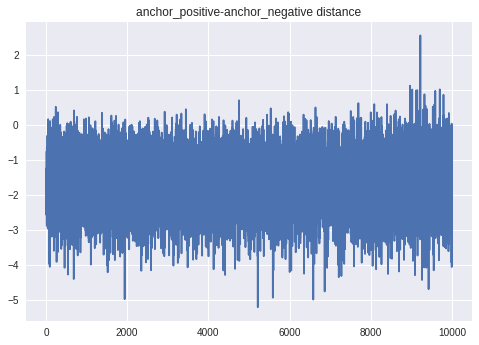

In [97]:
diff=a_p-a_n
plt.plot(diff)
plt.title("anchor_positive-anchor_negative distance")

#### Metric Part

In [0]:
def create_metric_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    print ("entering network")
    input = Input(shape=input_shape)
    print (input.shape)
    
    x=Dense(1024, name='first',kernel_initializer="glorot_normal")(input)
    x=BatchNormalization(momentum=0.99, epsilon=0.001, beta_initializer='zeros', gamma_initializer='ones')(x)
    x=LeakyReLU(alpha=.001)(x)
    print (x.shape)
    x=Dense(512, name='second',kernel_initializer="glorot_normal")(x)
    x=BatchNormalization(momentum=0.99, epsilon=0.001, beta_initializer='zeros', gamma_initializer='ones')(x)
    x=LeakyReLU(alpha=.001)(x)
    print (x.shape)
    x=Dense(1, name='third',kernel_initializer="glorot_normal")(x)
    x=BatchNormalization(momentum=0.99, epsilon=0.001, beta_initializer='zeros', gamma_initializer='ones')(x)
    x=LeakyReLU(alpha=.001)(x)
    print (x.shape)
    print ("exiting network")
    return Model(input, x)

In [99]:
in_dim=8192
inp=(in_dim,)
output_FC=(1,)
metric_network=create_metric_network(inp)
a_p=Input(shape=inp)
a_n=Input(shape=inp)

anch_pos=metric_network(a_p)
anch_neg=metric_network(a_n)

merged_vector = concatenate([anch_pos, anch_neg],axis=-1)
prob=Dense(2, activation='softmax', name='third')(merged_vector)
model_fc = Model(inputs=[a_p,a_n], outputs=prob)

entering network
(?, 8192)
(?, 1024)
(?, 512)
(?, 1)
exiting network


In [100]:
model_fc.compile(optimizer=Adam(lr=learning_rate),
              loss='binary_crossentropy',metrics=["accuracy"])
#sys.exit(0)
y_true=np.array([np.ones((data_instances)),np.zeros((data_instances))])
label=y_true.T

print (label.shape)
metric_a_p=np.reshape((metric_a_p),(len(metric_a_p),in_dim))
print (metric_a_p.shape)
metric_a_n=np.reshape((metric_a_n),(len(metric_a_n),in_dim))
# Training the model
model_fc.fit([metric_a_p,metric_a_n],[label] ,validation_split=0.2,batch_size=64, epochs=epoch)

(10000, 2)
(10000, 8192)
Train on 8000 samples, validate on 2000 samples
Epoch 1/80
8000/8000 [==============================] - 8s 988us/step - loss: 0.6422 - acc: 0.7496 - val_loss: 0.6066 - val_acc: 0.7380
Epoch 2/80
8000/8000 [==============================] - 4s 553us/step - loss: 0.4513 - acc: 0.9749 - val_loss: 0.4954 - val_acc: 1.0000
Epoch 3/80
8000/8000 [==============================] - 4s 550us/step - loss: 0.3421 - acc: 0.9954 - val_loss: 0.4298 - val_acc: 1.0000
Epoch 4/80
7488/8000 [===========================>..] - ETA: 0s - loss: 0.2687 - acc: 0.9991

8000/8000 [==============================] - 4s 545us/step - loss: 0.2670 - acc: 0.9991 - val_loss: 0.3738 - val_acc: 1.0000
Epoch 5/80
8000/8000 [==============================] - 4s 553us/step - loss: 0.2126 - acc: 1.0000 - val_loss: 0.3071 - val_acc: 1.0000
Epoch 6/80
8000/8000 [==============================] - 4s 541us/step - loss: 0.1718 - acc: 1.0000 - val_loss: 0.2959 - val_acc: 1.0000
Epoch 7/80
8000/8000 [==============================] - 4s 548us/step - loss: 0.1393 - acc: 1.0000 - val_loss: 0.2547 - val_acc: 1.0000
Epoch 8/80
6080/8000 [=====================>........] - ETA: 0s - loss: 0.1148 - acc: 1.0000

8000/8000 [==============================] - 4s 543us/step - loss: 0.1123 - acc: 1.0000 - val_loss: 0.2432 - val_acc: 1.0000
Epoch 9/80
8000/8000 [==============================] - 4s 544us/step - loss: 0.0919 - acc: 0.9999 - val_loss: 0.2235 - val_acc: 1.0000
Epoch 10/80
8000/8000 [==============================] - 4s 544us/step - loss: 0.0736 - acc: 1.0000 - val_loss: 0.1998 - val_acc: 0.9945
Epoch 11/80
8000/8000 [==============================] - 4s 547us/step - loss: 0.0578 - acc: 1.0000 - val_loss: 0.1950 - val_acc: 1.0000
Epoch 12/80
5568/8000 [===================>..........] - ETA: 1s - loss: 0.0475 - acc: 1.0000

8000/8000 [==============================] - 4s 541us/step - loss: 0.0461 - acc: 1.0000 - val_loss: 0.0232 - val_acc: 1.0000
Epoch 13/80
8000/8000 [==============================] - 4s 545us/step - loss: 0.0361 - acc: 1.0000 - val_loss: 0.0132 - val_acc: 1.0000
Epoch 14/80
8000/8000 [==============================] - 4s 540us/step - loss: 0.0287 - acc: 1.0000 - val_loss: 0.0282 - val_acc: 1.0000
Epoch 15/80
8000/8000 [==============================] - 4s 543us/step - loss: 0.0238 - acc: 1.0000 - val_loss: 0.1653 - val_acc: 1.0000
Epoch 16/80
5440/8000 [===================>..........] - ETA: 1s - loss: 0.0204 - acc: 1.0000

8000/8000 [==============================] - 4s 543us/step - loss: 0.0200 - acc: 1.0000 - val_loss: 0.0155 - val_acc: 1.0000
Epoch 17/80
8000/8000 [==============================] - 4s 544us/step - loss: 0.0169 - acc: 1.0000 - val_loss: 0.0459 - val_acc: 1.0000
Epoch 18/80
8000/8000 [==============================] - 4s 543us/step - loss: 0.0164 - acc: 1.0000 - val_loss: 0.1275 - val_acc: 1.0000
Epoch 19/80
8000/8000 [==============================] - 4s 543us/step - loss: 0.0133 - acc: 1.0000 - val_loss: 0.1579 - val_acc: 1.0000
Epoch 20/80
5184/8000 [==================>...........] - ETA: 1s - loss: 0.0112 - acc: 1.0000

8000/8000 [==============================] - 4s 546us/step - loss: 0.0111 - acc: 1.0000 - val_loss: 0.0677 - val_acc: 1.0000
Epoch 21/80
8000/8000 [==============================] - 4s 544us/step - loss: 0.0093 - acc: 1.0000 - val_loss: 2.6398e-04 - val_acc: 1.0000
Epoch 22/80
8000/8000 [==============================] - 4s 548us/step - loss: 0.0069 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 1.0000
Epoch 23/80
8000/8000 [==============================] - 4s 546us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 2.8439e-04 - val_acc: 1.0000
Epoch 24/80
4800/8000 [=================>............] - ETA: 1s - loss: 0.0037 - acc: 1.0000

8000/8000 [==============================] - 4s 549us/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0106 - val_acc: 1.0000
Epoch 25/80
8000/8000 [==============================] - 4s 541us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0064 - val_acc: 1.0000
Epoch 26/80
8000/8000 [==============================] - 4s 541us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0447 - val_acc: 1.0000
Epoch 27/80
8000/8000 [==============================] - 4s 543us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 28/80
5184/8000 [==================>...........] - ETA: 1s - loss: 0.0015 - acc: 1.0000

8000/8000 [==============================] - 4s 545us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 29/80
8000/8000 [==============================] - 4s 550us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.1476 - val_acc: 1.0000
Epoch 30/80
8000/8000 [==============================] - 4s 550us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 31/80
8000/8000 [==============================] - 4s 544us/step - loss: 9.9096e-04 - acc: 1.0000 - val_loss: 7.5833e-04 - val_acc: 1.0000
Epoch 32/80
5568/8000 [===================>..........] - ETA: 1s - loss: 0.0012 - acc: 1.0000

8000/8000 [==============================] - 4s 546us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0110 - val_acc: 1.0000
Epoch 33/80
8000/8000 [==============================] - 4s 548us/step - loss: 9.2621e-04 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 34/80
8000/8000 [==============================] - 4s 553us/step - loss: 7.5751e-04 - acc: 1.0000 - val_loss: 9.5641e-05 - val_acc: 1.0000
Epoch 35/80
8000/8000 [==============================] - 4s 549us/step - loss: 7.0995e-04 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 36/80
4672/8000 [================>.............] - ETA: 1s - loss: 5.3279e-04 - acc: 1.0000

8000/8000 [==============================] - 4s 547us/step - loss: 4.7727e-04 - acc: 1.0000 - val_loss: 0.0064 - val_acc: 1.0000
Epoch 37/80
8000/8000 [==============================] - 4s 552us/step - loss: 3.7760e-04 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 38/80
8000/8000 [==============================] - 4s 547us/step - loss: 4.7247e-04 - acc: 1.0000 - val_loss: 1.0099e-04 - val_acc: 1.0000
Epoch 39/80
8000/8000 [==============================] - 4s 549us/step - loss: 4.8216e-04 - acc: 1.0000 - val_loss: 6.7171e-05 - val_acc: 1.0000
Epoch 40/80
4672/8000 [================>.............] - ETA: 1s - loss: 4.1217e-04 - acc: 1.0000

8000/8000 [==============================] - 4s 546us/step - loss: 3.6591e-04 - acc: 1.0000 - val_loss: 7.0147e-04 - val_acc: 1.0000
Epoch 41/80
8000/8000 [==============================] - 4s 541us/step - loss: 3.5179e-04 - acc: 1.0000 - val_loss: 3.5260e-04 - val_acc: 1.0000
Epoch 42/80
8000/8000 [==============================] - 4s 548us/step - loss: 2.9624e-04 - acc: 1.0000 - val_loss: 4.8602e-04 - val_acc: 1.0000
Epoch 43/80
8000/8000 [==============================] - 4s 545us/step - loss: 2.3204e-04 - acc: 1.0000 - val_loss: 4.0140e-04 - val_acc: 1.0000
Epoch 44/80
4160/8000 [==============>...............] - ETA: 1s - loss: 1.9509e-04 - acc: 1.0000

8000/8000 [==============================] - 4s 546us/step - loss: 1.9196e-04 - acc: 1.0000 - val_loss: 3.3097e-04 - val_acc: 1.0000
Epoch 45/80
8000/8000 [==============================] - 4s 547us/step - loss: 4.2504e-04 - acc: 1.0000 - val_loss: 1.0960e-07 - val_acc: 1.0000
Epoch 46/80
8000/8000 [==============================] - 4s 550us/step - loss: 3.8251e-04 - acc: 1.0000 - val_loss: 7.0865e-04 - val_acc: 1.0000
Epoch 47/80
8000/8000 [==============================] - 4s 542us/step - loss: 2.3033e-04 - acc: 1.0000 - val_loss: 0.1519 - val_acc: 1.0000
Epoch 48/80
3648/8000 [============>.................] - ETA: 2s - loss: 1.8598e-04 - acc: 1.0000

8000/8000 [==============================] - 4s 548us/step - loss: 1.4891e-04 - acc: 1.0000 - val_loss: 0.0185 - val_acc: 1.0000
Epoch 49/80
8000/8000 [==============================] - 4s 549us/step - loss: 1.2166e-04 - acc: 1.0000 - val_loss: 0.1230 - val_acc: 1.0000
Epoch 50/80
8000/8000 [==============================] - 4s 550us/step - loss: 1.3796e-04 - acc: 1.0000 - val_loss: 2.3964e-04 - val_acc: 1.0000
Epoch 51/80
8000/8000 [==============================] - 4s 550us/step - loss: 1.0392e-04 - acc: 1.0000 - val_loss: 1.3668e-04 - val_acc: 1.0000
Epoch 52/80
4288/8000 [===============>..............] - ETA: 1s - loss: 1.0993e-04 - acc: 1.0000

8000/8000 [==============================] - 4s 539us/step - loss: 1.4708e-04 - acc: 1.0000 - val_loss: 1.5725e-05 - val_acc: 1.0000
Epoch 53/80
8000/8000 [==============================] - 4s 542us/step - loss: 8.8891e-05 - acc: 1.0000 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 54/80
8000/8000 [==============================] - 4s 545us/step - loss: 2.6671e-04 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 1.0000
Epoch 55/80
8000/8000 [==============================] - 4s 543us/step - loss: 3.8513e-04 - acc: 1.0000 - val_loss: 2.1464e-05 - val_acc: 1.0000
Epoch 56/80
4544/8000 [================>.............] - ETA: 1s - loss: 1.4396e-04 - acc: 1.0000

8000/8000 [==============================] - 4s 538us/step - loss: 1.4489e-04 - acc: 1.0000 - val_loss: 3.3176e-04 - val_acc: 1.0000
Epoch 57/80
8000/8000 [==============================] - 4s 547us/step - loss: 1.2737e-04 - acc: 1.0000 - val_loss: 8.1624e-05 - val_acc: 1.0000
Epoch 58/80
8000/8000 [==============================] - 4s 545us/step - loss: 1.2527e-04 - acc: 1.0000 - val_loss: 0.0092 - val_acc: 1.0000
Epoch 59/80
8000/8000 [==============================] - 4s 547us/step - loss: 9.1206e-05 - acc: 1.0000 - val_loss: 4.5400e-04 - val_acc: 1.0000
Epoch 60/80
4416/8000 [===============>..............] - ETA: 1s - loss: 3.5654e-04 - acc: 1.0000

8000/8000 [==============================] - 4s 546us/step - loss: 2.8871e-04 - acc: 1.0000 - val_loss: 0.0913 - val_acc: 1.0000
Epoch 61/80
8000/8000 [==============================] - 4s 543us/step - loss: 9.2903e-05 - acc: 1.0000 - val_loss: 2.4629e-04 - val_acc: 1.0000
Epoch 62/80
8000/8000 [==============================] - 4s 546us/step - loss: 2.7303e-04 - acc: 1.0000 - val_loss: 0.1205 - val_acc: 1.0000
Epoch 63/80
8000/8000 [==============================] - 4s 541us/step - loss: 1.6914e-04 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 64/80
4544/8000 [================>.............] - ETA: 1s - loss: 1.8285e-04 - acc: 1.0000

8000/8000 [==============================] - 4s 543us/step - loss: 1.7561e-04 - acc: 1.0000 - val_loss: 5.1923e-06 - val_acc: 1.0000
Epoch 65/80
8000/8000 [==============================] - 4s 543us/step - loss: 5.1154e-05 - acc: 1.0000 - val_loss: 1.9009e-04 - val_acc: 1.0000
Epoch 66/80
8000/8000 [==============================] - 4s 544us/step - loss: 7.3233e-05 - acc: 1.0000 - val_loss: 7.6447e-05 - val_acc: 1.0000
Epoch 67/80
8000/8000 [==============================] - 4s 550us/step - loss: 4.5744e-05 - acc: 1.0000 - val_loss: 6.1520e-04 - val_acc: 1.0000
Epoch 68/80
3776/8000 [=============>................] - ETA: 2s - loss: 3.8097e-05 - acc: 1.0000

8000/8000 [==============================] - 4s 549us/step - loss: 4.1818e-05 - acc: 1.0000 - val_loss: 2.1391e-04 - val_acc: 1.0000
Epoch 69/80
8000/8000 [==============================] - 4s 548us/step - loss: 1.0820e-04 - acc: 1.0000 - val_loss: 2.9428e-04 - val_acc: 1.0000
Epoch 70/80
8000/8000 [==============================] - 4s 536us/step - loss: 2.1394e-05 - acc: 1.0000 - val_loss: 6.4654e-05 - val_acc: 1.0000
Epoch 71/80
8000/8000 [==============================] - 4s 537us/step - loss: 2.0691e-05 - acc: 1.0000 - val_loss: 9.3646e-05 - val_acc: 1.0000
Epoch 72/80
4288/8000 [===============>..............] - ETA: 1s - loss: 1.7566e-05 - acc: 1.0000

8000/8000 [==============================] - 4s 541us/step - loss: 1.6191e-05 - acc: 1.0000 - val_loss: 1.9598e-04 - val_acc: 1.0000
Epoch 73/80
8000/8000 [==============================] - 4s 545us/step - loss: 2.9991e-05 - acc: 1.0000 - val_loss: 0.0559 - val_acc: 1.0000
Epoch 74/80
8000/8000 [==============================] - 4s 546us/step - loss: 1.4423e-05 - acc: 1.0000 - val_loss: 4.2628e-04 - val_acc: 1.0000
Epoch 75/80
8000/8000 [==============================] - 4s 543us/step - loss: 2.4347e-05 - acc: 1.0000 - val_loss: 0.1182 - val_acc: 1.0000
Epoch 76/80
4160/8000 [==============>...............] - ETA: 1s - loss: 2.6386e-05 - acc: 1.0000

8000/8000 [==============================] - 4s 547us/step - loss: 1.8764e-05 - acc: 1.0000 - val_loss: 3.2759e-05 - val_acc: 1.0000
Epoch 77/80
8000/8000 [==============================] - 4s 542us/step - loss: 1.0799e-05 - acc: 1.0000 - val_loss: 9.9356e-05 - val_acc: 1.0000
Epoch 78/80
8000/8000 [==============================] - 4s 544us/step - loss: 1.3069e-05 - acc: 1.0000 - val_loss: 7.1281e-06 - val_acc: 1.0000
Epoch 79/80
8000/8000 [==============================] - 4s 540us/step - loss: 2.6478e-05 - acc: 1.0000 - val_loss: 2.1790e-04 - val_acc: 1.0000
Epoch 80/80
4672/8000 [================>.............] - ETA: 1s - loss: 7.9696e-06 - acc: 1.0000

8000/8000 [==============================] - 4s 542us/step - loss: 1.0663e-05 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000


In [0]:

model_fc.save_weights(FC_model)

In [0]:
model_fc.load_weights(FC_model,'r')

In [107]:
test_x=load_data(path+"test_triplet_dataset")
#x=np.array(x,dtype=np.uint8)
#data_instances=len(x)
print (test_x.shape)
test_instances=len(test_x)

(858, 3, 64, 64, 3)


In [108]:
in1=np.reshape(test_x[:,0,:,:,0],(test_instances,64,64,1))
in2=np.reshape(test_x[:,1,:,:,0],(test_instances,64,64,1))
in3=np.reshape(test_x[:,2,:,:,0],(test_instances,64,64,1))
pred=model.predict([in1,in2,in3])
print (pred.shape)
#metric_a_p=np.array((np.concatenate((pred[:,0:4096],pred[:,0:4096]))))
#metric_a_n=np.array((np.concatenate((pred[:,4096:8192],pred[:,8192:12288]))))
#print (metric_a_p.shape,metric_a_n.shape)
a=pred[:,0:4096]
p=pred[:,4096:8192]
n=pred[:,8192:12288]
metric_a_p=np.array([np.append(a[d,:], p[d,:]) for d in range(len(a))]) 
#metric_a_p=np.array((np.concatenate((pred[:,0:4096],pred[:,4096:8192]))))
#metric_a_n=np.array((np.concatenate((pred[:,0:4096],pred[:,8192:12288]))))
metric_a_n=np.array([np.append(a[d,:], n[d,:]) for d in range(len(a))])
print (metric_a_p.shape,metric_a_n.shape)

(858, 12288)
(858, 8192) (858, 8192)


In [109]:
model_fc.inputs

[<tf.Tensor 'input_18:0' shape=(?, 8192) dtype=float32>,
 <tf.Tensor 'input_19:0' shape=(?, 8192) dtype=float32>]

In [0]:
#with open(path+name+"FC_10000_triplet_weights_nd.json", 'r') as f:
#    model_fc=model_from_json(f.read())
#model_fc.load_weights(path+name+"FC_10000_triplet_weights_nd.h5",'r')
#model_fc.inputs

In [112]:

pred=model_fc.predict([metric_a_p,metric_a_n])

print (pred)
#print (pred[:,1])
print(label[1715,0])
print(len(pred))
count_positive = 0;
count_negative = 0;
for l in range(0,858):
  #print(label[l])
  if pred[l,0] > pred[l,1]:
     count_positive = count_positive + 1;

      
print(count_positive)

  
#print(metric_a_p)
#print(metric_a_n)

[[9.9999630e-01 3.7288291e-06]
 [9.9999964e-01 4.1235151e-07]
 [9.9999917e-01 8.1361310e-07]
 ...
 [9.9999535e-01 4.6865948e-06]
 [9.9999750e-01 2.5115605e-06]
 [9.9998617e-01 1.3826318e-05]]
1.0
858
858


In [115]:
from sklearn.metrics import precision_recall_fscore_support
score=precision_recall_fscore_support((label[0:858,0]), pred[0:858,0].round(), average='macro')
#precision_recall_fscore_support((label[858:1715,1]), pred[858:1715,1].round(), average='macro')
#print(label[858:1715,1])
#print( pred[858:1715,1])
#print( pred[0:858,0])
print (score)

(1.0, 1.0, 1.0, None)


In [116]:
test_x=load_data(path+"triplet_dataset")
#x=np.array(x,dtype=np.uint8)
#data_instances=len(x)
print (test_x.shape)
test_instances=len(test_x)

(468, 3, 64, 64, 3)


In [117]:
in1=np.reshape(test_x[:,0,:,:,0],(test_instances,64,64,1))
in2=np.reshape(test_x[:,1,:,:,0],(test_instances,64,64,1))
in3=np.reshape(test_x[:,2,:,:,0],(test_instances,64,64,1))
pred=model.predict([in1,in2,in3])
print (pred.shape)
#metric_a_p=np.array((np.concatenate((pred[:,0:4096],pred[:,0:4096]))))
#metric_a_n=np.array((np.concatenate((pred[:,4096:8192],pred[:,8192:12288]))))
#print (metric_a_p.shape,metric_a_n.shape)
a=pred[:,0:4096]
p=pred[:,4096:8192]
n=pred[:,8192:12288]
metric_a_p=np.array([np.append(a[d,:], p[d,:]) for d in range(len(a))]) 
#metric_a_p=np.array((np.concatenate((pred[:,0:4096],pred[:,4096:8192]))))
#metric_a_n=np.array((np.concatenate((pred[:,0:4096],pred[:,8192:12288]))))
metric_a_n=np.array([np.append(a[d,:], n[d,:]) for d in range(len(a))])
print (metric_a_p.shape,metric_a_n.shape)

(468, 12288)
(468, 8192) (468, 8192)


In [120]:
pred=model_fc.predict([metric_a_p,metric_a_n])

print (pred)
#print (pred[:,1])
print(label[1715,0])
print(len(pred))
count_positive = 0;
count_negative = 0;
for l in range(0,468):
  #print(label[l])
  if pred[l,0] > pred[l,1]:
     count_positive = count_positive + 1;

      
print(count_positive)


[[9.99994755e-01 5.27340899e-06]
 [9.99999523e-01 4.82669179e-07]
 [9.99999404e-01 5.38254994e-07]
 [9.99999046e-01 9.10261917e-07]
 [9.99999046e-01 9.49540492e-07]
 [9.99967456e-01 3.25420224e-05]
 [9.99999523e-01 4.39139711e-07]
 [9.99999404e-01 5.57048509e-07]
 [9.99999523e-01 4.34154828e-07]
 [9.99999523e-01 4.64303241e-07]
 [9.99999523e-01 4.55669436e-07]
 [9.99997973e-01 1.99425608e-06]
 [9.99978304e-01 2.17291217e-05]
 [9.99998689e-01 1.35027665e-06]
 [9.99999523e-01 4.82977669e-07]
 [9.99999523e-01 4.86321198e-07]
 [9.99999642e-01 3.83396156e-07]
 [9.99996543e-01 3.41505779e-06]
 [9.99995589e-01 4.39857013e-06]
 [9.99999166e-01 8.31784234e-07]
 [9.99996781e-01 3.20737968e-06]
 [9.99991894e-01 8.12149483e-06]
 [9.99993324e-01 6.63636001e-06]
 [9.99998450e-01 1.49395851e-06]
 [9.99999404e-01 5.76920627e-07]
 [9.99980211e-01 1.98375656e-05]
 [9.99993682e-01 6.37045787e-06]
 [9.99983788e-01 1.61837233e-05]
 [9.99985218e-01 1.47741075e-05]
 [9.99994040e-01 6.00252724e-06]
 [9.999899

In [122]:
from sklearn.metrics import precision_recall_fscore_support
score=precision_recall_fscore_support((label[0:468,0]), pred[0:468,0].round(), average='macro')
#precision_recall_fscore_support((label[858:1715,1]), pred[858:1715,1].round(), average='macro')
#print(label[858:1715,1])
#print( pred[858:1715,1])
#print( pred[0:858,0])
print (score)

(1.0, 1.0, 1.0, None)
